In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
import kerastuner as kt
import tensorflow as tf
from keras.optimizers import Adam, Adamax, SGD
from kerastuner.tuners import RandomSearch

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/test_features.csv


Used notebooks:<br>
https://www.kaggle.com/simakov/keras-multilabel-neural-network-v1-2/notebook<br>
https://www.kaggle.com/elcaiseri/moa-keras-multilabel-classifier-nn-starter/notebook<br>
https://www.kaggle.com/gogo827jz/moa-lstm-pure-transformer-fast-and-not-bad/notebook?scriptVersionId=42679125<br>

## Reading data

In [2]:
path = "/kaggle/input/lish-moa/"
train_features = pd.read_csv(path+"train_features.csv")
test_features = pd.read_csv(path+"test_features.csv")
train_targets_scored = pd.read_csv(path+"train_targets_scored.csv")
sub = pd.read_csv(path+"sample_submission.csv")

# From https://www.kaggle.com/carlmcbrideellis/moa-setting-ctl-vehicle-0-improves-score
train_features.at[train_features['cp_type'].str.contains('ctl_vehicle'),train_features.filter(regex='-.*').columns] = 0.0
test_features.at[test_features['cp_type'].str.contains('ctl_vehicle'),test_features.filter(regex='-.*').columns] = 0.0

## Data Preparations

In [3]:
def onehotencode(data):
    data = pd.get_dummies(data)
    return data

In [4]:
# train data, dropping id column and onehot encoding
X_train = train_features.copy()
y_train = train_targets_scored.copy()
X_train = X_train.drop("sig_id", axis=1)
y_train = y_train.drop("sig_id", axis=1)

X_train = onehotencode(X_train)

X_test = test_features.copy()
sig_id = X_test["sig_id"]
X_test = X_test.drop("sig_id", axis=1)
X_test = onehotencode(X_test)

columns = X_test.columns  # getting the column names

# scaling seemed to hurt performance

## Modelling

In [5]:
# Using Keras Tuner for parameters and architecture
def build_model(hp):
    model = Sequential()
    model.add(Input(877))
    model.add(BatchNormalization())
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(Dropout(hp.Choice('dropout_' + str(i), [0.5, 0.6, 0.7, 0.8, 0.9])))
        model.add(Dense(units=hp.Int('units_' + str(i),
                                     min_value=200,
                                     max_value=2048,
                                     step=64),
                        activation="sigmoid"))
    model.add(Dense(206, activation='sigmoid'))
    model.compile(optimizer=hp.Choice('optimizer', ["adam", "adamax"]),
                  loss='binary_crossentropy',
                  metrics=['accuracy']
                 )
    return model

In [6]:
# tuner = RandomSearch(build_model,
#                     objective='val_loss',
#                     max_trials=10,
#                     executions_per_trial=3,
#                     directory='project',
#                     project_name='MoA')

# X_trn_tuner, X_test_tuner, y_trn_tuner, y_test_tuner = train_test_split(X_train, y_train, test_size=0.3, random_state=0)
# tuner.search(X_trn_tuner, y_trn_tuner, epochs=25, validation_data=(X_test_tuner, y_test_tuner))

# tuner.results_summary()

In [7]:
def create_model(n_input):
    model = Sequential()
    model.add(Input(n_input))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(300, kernel_initializer='he_uniform', activation='sigmoid'))
    model.add(Dropout(0.6)) 
    model.add(Dense(300, activation='sigmoid'))
    model.add(Dropout(0.6))
    model.add(Dense(700, activation='sigmoid'))
    model.add(Dropout(0.6))
    model.add(Dense(206, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
    return model

In [8]:
model = create_model(len(columns))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 877)               3508      
_________________________________________________________________
dropout (Dropout)            (None, 877)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               263400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 700)               2

In [9]:
hist = model.fit(X_train, y_train, batch_size=32, validation_split=0.2, verbose=1, epochs=100)

Epoch 1/100
596/596 [==============================] - 2s 4ms/step - loss: 0.0299 - accuracy: 0.0116 - val_loss: 0.0213 - val_accuracy: 0.0334
Epoch 2/100
596/596 [==============================] - 2s 3ms/step - loss: 0.0223 - accuracy: 0.0229 - val_loss: 0.0204 - val_accuracy: 0.0500
Epoch 3/100
596/596 [==============================] - 2s 3ms/step - loss: 0.0212 - accuracy: 0.0265 - val_loss: 0.0198 - val_accuracy: 0.0426
Epoch 4/100
596/596 [==============================] - 3s 4ms/step - loss: 0.0206 - accuracy: 0.0300 - val_loss: 0.0194 - val_accuracy: 0.0304
Epoch 5/100
596/596 [==============================] - 2s 3ms/step - loss: 0.0201 - accuracy: 0.0334 - val_loss: 0.0191 - val_accuracy: 0.0340
Epoch 6/100
596/596 [==============================] - 2s 3ms/step - loss: 0.0197 - accuracy: 0.0362 - val_loss: 0.0187 - val_accuracy: 0.0386
Epoch 7/100
596/596 [==============================] - 2s 3ms/step - loss: 0.0193 - accuracy: 0.0411 - val_loss: 0.0185 - val_accuracy: 0.0414

Text(0.5, 1.0, 'Accuracy')

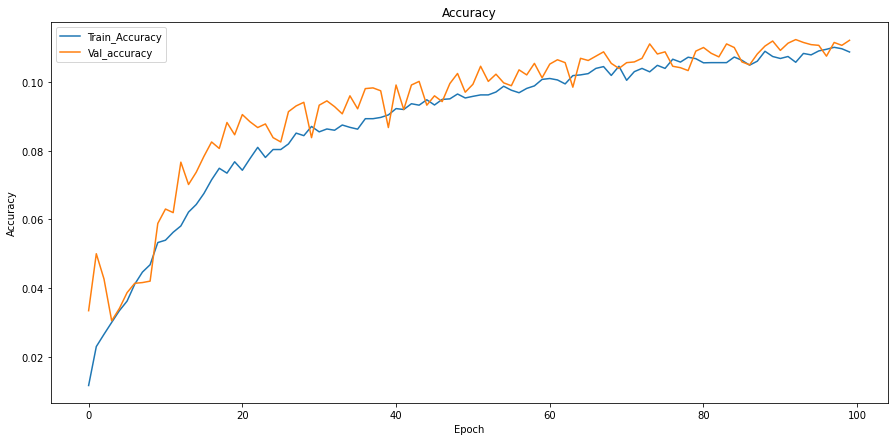

In [10]:
# Draw fitting info
plt.figure(figsize=(15, 7))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train_Accuracy', 'Val_accuracy'])
plt.title('Accuracy')

In [11]:
preds = model.predict(X_test)
submission = pd.DataFrame.from_records(preds)
submission.insert(0, "sig_id", sig_id)
submission.columns = sub.columns
submission.to_csv('submission.csv', index=False)